In [1]:
import tensorflow as tf
import keras
from utils import constants
from utils.preprocessor import Preprocessor
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from modules.data_loader import DataLoader
from modules.losses import masked_loss
from modules.diacritizer import Diacritizer
from modules.trainer import Trainer
import yaml
from models.rnn_model import RNNModel

keras.utils.set_random_seed(2024)

In [47]:
ca_train_df, ca_val_df, ca_test_df = pd.read_csv('./dataset/Tashkeela-clean/CA/CA_train.csv'), pd.read_csv('./dataset/Tashkeela-clean/CA/CA_val.csv'), pd.read_csv('./dataset/Tashkeela-clean/CA/CA_test.csv')
msa_train_df, msa_val_df, msa_test_df = pd.read_csv('./dataset/Tashkeela-clean/MSA/MSA_train.csv'), pd.read_csv('./dataset/Tashkeela-clean/MSA/MSA_val.csv'), pd.read_csv('./dataset/Tashkeela-clean/MSA/MSA_test.csv')

In [48]:
ca_train_df

,text,words,chars,chars_no_diac
0,وَفِي بَعْضِ النُّسَخِ بِالْإِضَافَةِ فَصَالَح...,60,479,285
1,غَيْرِ وَلِيِّ مَنْ ذُكِرَ دَفْعُ سِنٍّ أَعْلَ...,14,100,60
2,وَمِمَّنْ حَكَى أَنْ يُعَلِّمُ بِمَعْنَى أَعْل...,9,90,51
3,وَيَخْرُجُ بِتَعْبِيرِ الْمَالِ الْمَنْفَعَةُ ...,15,156,91
4,زَوْجَانِ كَافِرَانِ أَسْلَمَتْ الْمَرْأَةُ وَ...,28,248,145
...,...,...,...,...
2365073,إنْ ظَهَرَتْ قَرِينَةٌ تُقَوِّي صِدْقَ السَّيّ...,25,202,117
2365074,لِأَنَّهُ يُعَارِضُ ظَاهِرَ الزَّوْجِ بِالْيَد...,8,70,41
2365075,وَإِلَّا لَمْ يَقَعْ فَرْضًا وَلَا نَفْلًا قَا...,9,73,43
2365076,رَوَاهُ مُسْلِمٌ فِى الصَّحِيحِ عَنْ عَمْرٍو ا...,9,70,43


In [50]:
txt = ca_train_df.text.iloc[0]

In [53]:
a, b = Preprocessor.strip_tashkeel(txt)

In [55]:
print(a)

['و', 'ف', 'ي', ' ', 'ب', 'ع', 'ض', ' ', 'ا', 'ل', 'ن', 'س', 'خ', ' ', 'ب', 'ا', 'ل', 'إ', 'ض', 'ا', 'ف', 'ة', ' ', 'ف', 'ص', 'ا', 'ل', 'ح', ' ', 'ا', 'ل', 'ر', 'ج', 'ل', ' ', 'ا', 'ل', 'م', 'ر', 'ي', 'ض', ' ', 'ع', 'ل', 'ى', ' ', 'ج', 'ر', 'ح', 'ه', ' ', 'ف', 'ي', ' ', 'ح', 'ا', 'ل', ' ', 'م', 'ر', 'ض', 'ه', ' ', 'م', 'ن', ' ', 'ا', 'ل', 'ج', 'ر', 'ح', ' ', 'ب', ' ', 'م', 'ا', 'ل', ' ', 'ق', 'د', 'ر', ' ', 'أ', 'ر', 'ش', 'ه', ' ', 'أ', 'ي', ' ', 'د', 'ي', 'ة', ' ', 'ا', 'ل', 'ج', 'ر', 'ح', ' ', 'أ', 'و', ' ', 'غ', 'ي', 'ر', 'ه', ' ', 'أ', 'ي', ' ', 'ا', 'ل', 'أ', 'ر', 'ش', ' ', 'ص', 'ا', 'د', 'ق', ' ', 'ب', 'أ', 'ق', 'ل', ' ', 'و', 'أ', 'ك', 'ث', 'ر', ' ', 'م', 'ن', 'ه', ' ', 'ث', 'م', ' ', 'م', 'ا', 'ت', ' ', 'ا', 'ل', 'م', 'ر', 'ي', 'ض', ' ', 'م', 'ن', ' ', 'م', 'ر', 'ض', 'ه', ' ', 'م', 'ن', ' ', 'ذ', 'ل', 'ك', ' ', 'ا', 'ل', 'ج', 'ر', 'ح', ' ', 'ج', 'ا', 'ز', ' ', 'ص', 'ل', 'ح', 'ه', ' ', 'ا', 'ب', 'ت', 'د', 'ا', 'ء', ' ', 'و', 'ل', 'ز', 'م', ' ', 'ص', 'ل', 'ح', 'ه', ' ', 'ب', 'ع',

In [56]:
print(b)

['َ', 'ِ', ' ', ' ', 'َ', 'ْ', 'ِ', ' ', ' ', ' ', 'ُّ', 'َ', 'ِ', ' ', 'ِ', ' ', 'ْ', 'ِ', 'َ', ' ', 'َ', 'ِ', ' ', 'َ', 'َ', ' ', 'َ', 'َ', ' ', ' ', ' ', 'َّ', 'ُ', 'ُ', ' ', ' ', 'ْ', 'َ', 'ِ', ' ', 'َ', ' ', 'َ', 'َ', ' ', ' ', 'ُ', 'ْ', 'ِ', 'ِ', ' ', 'ِ', ' ', ' ', 'َ', ' ', 'ِ', ' ', 'َ', 'َ', 'ِ', 'ِ', ' ', 'ِ', 'ْ', ' ', ' ', 'ْ', 'ُ', 'ْ', 'ِ', ' ', 'ِ', ' ', 'َ', ' ', 'ٍ', ' ', 'َ', 'ْ', 'ِ', ' ', 'َ', 'ْ', 'ِ', 'ِ', ' ', 'َ', 'ْ', ' ', 'ِ', 'َ', 'ِ', ' ', ' ', 'ْ', 'ُ', 'ْ', 'ِ', ' ', 'َ', 'ْ', ' ', 'َ', 'ْ', 'ِ', 'ِ', ' ', 'َ', 'ْ', ' ', ' ', 'ْ', 'َ', 'ْ', 'ِ', ' ', 'َ', ' ', 'ِ', 'ٌ', ' ', 'ِ', 'َ', 'َ', 'َّ', ' ', 'َ', 'َ', 'ْ', 'َ', 'َ', ' ', 'ِ', 'ْ', 'ُ', ' ', 'ُ', 'َّ', ' ', 'َ', ' ', 'َ', ' ', ' ', 'ْ', 'َ', 'ِ', ' ', 'ُ', ' ', 'ِ', 'ْ', ' ', 'َ', 'َ', 'ِ', 'ِ', ' ', 'ِ', 'ْ', ' ', 'َ', 'ِ', 'َ', ' ', ' ', 'ْ', 'ُ', 'ْ', 'ِ', ' ', 'َ', ' ', 'َ', ' ', 'ُ', 'ْ', 'ُ', 'ُ', ' ', ' ', 'ْ', 'ِ', 'َ', ' ', 'ً', ' ', 'َ', 'َ', 'ِ', 'َ', ' ', 'ُ', 'ْ', 'ُ', 'ُ', ' ', 'َ', 

In [4]:
letters_tok = keras.layers.TextVectorization(
    ragged=True,
    standardize=lambda x:tf.concat([["s"], x, ["e"]], axis=-1),
    split=None,
    vocabulary=constants.get_letters_vocabulary(),
    )

diac_tok = keras.layers.TextVectorization(
    ragged=True,
    standardize=lambda x:tf.concat([[" "], x, [" "]], axis=-1),
    split=None,
    vocabulary=constants.get_diac_vocabulary()
    )

In [3]:
print(letters_tok.vocabulary_size(), letters_tok.get_vocabulary())

41 ['', '[UNK]', ' ', 's', 'e', 'ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي']


In [4]:
print(diac_tok.vocabulary_size(), diac_tok.get_vocabulary())

17 ['', '[UNK]', ' ', 'ً', 'ٌ', 'ٍ', 'َ', 'ُ', 'ِ', 'ّ', 'ْ', 'ًّ', 'َّ', 'ِّ', 'ٍّ', 'ُّ', 'ٌّ']


In [5]:
data_loader = DataLoader(letters_tok, diac_tok)

In [6]:
ca_train_raw = data_loader.from_csv('./dataset/Tashkeela-clean/CA/CA_train.csv')
ca_val_raw = data_loader.from_csv('./dataset/Tashkeela-clean/CA/CA_val.csv')
ca_test_raw = data_loader.from_csv('./dataset/Tashkeela-clean/CA/CA_test.csv')

msa_train_raw = data_loader.from_csv('./dataset/Tashkeela-clean/MSA/MSA_train.csv')
msa_val_raw = data_loader.from_csv('./dataset/Tashkeela-clean/MSA/MSA_val.csv')
msa_test_raw = data_loader.from_csv('./dataset/Tashkeela-clean/MSA/MSA_test.csv')

In [7]:
sample = next(iter(ca_train_raw))
sample

<tf.Tensor: shape=(), dtype=string, numpy=b'\xd9\x88\xd9\x8e\xd9\x81\xd9\x90\xd9\x8a \xd8\xa8\xd9\x8e\xd8\xb9\xd9\x92\xd8\xb6\xd9\x90 \xd8\xa7\xd9\x84\xd9\x86\xd9\x91\xd9\x8f\xd8\xb3\xd9\x8e\xd8\xae\xd9\x90 \xd8\xa8\xd9\x90\xd8\xa7\xd9\x84\xd9\x92\xd8\xa5\xd9\x90\xd8\xb6\xd9\x8e\xd8\xa7\xd9\x81\xd9\x8e\xd8\xa9\xd9\x90 \xd9\x81\xd9\x8e\xd8\xb5\xd9\x8e\xd8\xa7\xd9\x84\xd9\x8e\xd8\xad\xd9\x8e \xd8\xa7\xd9\x84\xd8\xb1\xd9\x91\xd9\x8e\xd8\xac\xd9\x8f\xd9\x84\xd9\x8f \xd8\xa7\xd9\x84\xd9\x92\xd9\x85\xd9\x8e\xd8\xb1\xd9\x90\xd9\x8a\xd8\xb6\xd9\x8e \xd8\xb9\xd9\x8e\xd9\x84\xd9\x8e\xd9\x89 \xd8\xac\xd9\x8f\xd8\xb1\xd9\x92\xd8\xad\xd9\x90\xd9\x87\xd9\x90 \xd9\x81\xd9\x90\xd9\x8a \xd8\xad\xd9\x8e\xd8\xa7\xd9\x84\xd9\x90 \xd9\x85\xd9\x8e\xd8\xb1\xd9\x8e\xd8\xb6\xd9\x90\xd9\x87\xd9\x90 \xd9\x85\xd9\x90\xd9\x86\xd9\x92 \xd8\xa7\xd9\x84\xd9\x92\xd8\xac\xd9\x8f\xd8\xb1\xd9\x92\xd8\xad\xd9\x90 \xd8\xa8\xd9\x90 \xd9\x85\xd9\x8e\xd8\xa7\xd9\x84\xd9\x8d \xd9\x82\xd9\x8e\xd8\xaf\xd9\x92\xd8\xb1\xd9\x90 \xd

In [67]:
a, b = data_loader.tf_strip_tashkeel(sample)

In [68]:
a

<tf.Tensor: shape=(285,), dtype=string, numpy=
array([b'\xd9\x88', b'\xd9\x81', b'\xd9\x8a', b' ', b'\xd8\xa8',
       b'\xd8\xb9', b'\xd8\xb6', b' ', b'\xd8\xa7', b'\xd9\x84',
       b'\xd9\x86', b'\xd8\xb3', b'\xd8\xae', b' ', b'\xd8\xa8',
       b'\xd8\xa7', b'\xd9\x84', b'\xd8\xa5', b'\xd8\xb6', b'\xd8\xa7',
       b'\xd9\x81', b'\xd8\xa9', b' ', b'\xd9\x81', b'\xd8\xb5',
       b'\xd8\xa7', b'\xd9\x84', b'\xd8\xad', b' ', b'\xd8\xa7',
       b'\xd9\x84', b'\xd8\xb1', b'\xd8\xac', b'\xd9\x84', b' ',
       b'\xd8\xa7', b'\xd9\x84', b'\xd9\x85', b'\xd8\xb1', b'\xd9\x8a',
       b'\xd8\xb6', b' ', b'\xd8\xb9', b'\xd9\x84', b'\xd9\x89', b' ',
       b'\xd8\xac', b'\xd8\xb1', b'\xd8\xad', b'\xd9\x87', b' ',
       b'\xd9\x81', b'\xd9\x8a', b' ', b'\xd8\xad', b'\xd8\xa7',
       b'\xd9\x84', b' ', b'\xd9\x85', b'\xd8\xb1', b'\xd8\xb6',
       b'\xd9\x87', b' ', b'\xd9\x85', b'\xd9\x86', b' ', b'\xd8\xa7',
       b'\xd9\x84', b'\xd8\xac', b'\xd8\xb1', b'\xd8\xad', b' ',
       b'\xd8\xa8

In [70]:
letters_tok.get_vocabulary()

['',
 '[UNK]',
 ' ',
 's',
 'e',
 'ء',
 'آ',
 'أ',
 'ؤ',
 'إ',
 'ئ',
 'ا',
 'ب',
 'ة',
 'ت',
 'ث',
 'ج',
 'ح',
 'خ',
 'د',
 'ذ',
 'ر',
 'ز',
 'س',
 'ش',
 'ص',
 'ض',
 'ط',
 'ظ',
 'ع',
 'غ',
 'ف',
 'ق',
 'ك',
 'ل',
 'م',
 'ن',
 'ه',
 'و',
 'ى',
 'ي']

In [69]:
letters_tok(a)

<tf.Tensor: shape=(287,), dtype=int64, numpy=
array([ 3, 38, 31, 40,  2, 12, 29, 26,  2, 11, 34, 36, 23, 18,  2, 12, 11,
       34,  9, 26, 11, 31, 13,  2, 31, 25, 11, 34, 17,  2, 11, 34, 21, 16,
       34,  2, 11, 34, 35, 21, 40, 26,  2, 29, 34, 39,  2, 16, 21, 17, 37,
        2, 31, 40,  2, 17, 11, 34,  2, 35, 21, 26, 37,  2, 35, 36,  2, 11,
       34, 16, 21, 17,  2, 12,  2, 35, 11, 34,  2, 32, 19, 21,  2,  7, 21,
       24, 37,  2,  7, 40,  2, 19, 40, 13,  2, 11, 34, 16, 21, 17,  2,  7,
       38,  2, 30, 40, 21, 37,  2,  7, 40,  2, 11, 34,  7, 21, 24,  2, 25,
       11, 19, 32,  2, 12,  7, 32, 34,  2, 38,  7, 33, 15, 21,  2, 35, 36,
       37,  2, 15, 35,  2, 35, 11, 14,  2, 11, 34, 35, 21, 40, 26,  2, 35,
       36,  2, 35, 21, 26, 37,  2, 35, 36,  2, 20, 34, 33,  2, 11, 34, 16,
       21, 17,  2, 16, 11, 22,  2, 25, 34, 17, 37,  2, 11, 12, 14, 19, 11,
        5,  2, 38, 34, 22, 35,  2, 25, 34, 17, 37,  2, 12, 29, 19,  2, 38,
       32, 38, 29, 37,  2, 31, 34, 40, 23,  2, 34, 38,

In [63]:
len(sample.numpy().decode('utf-8'))

479

In [8]:
sample.numpy().decode('utf-8')

'وَفِي بَعْضِ النُّسَخِ بِالْإِضَافَةِ فَصَالَحَ الرَّجُلُ الْمَرِيضَ عَلَى جُرْحِهِ فِي حَالِ مَرَضِهِ مِنْ الْجُرْحِ بِ مَالٍ قَدْرِ أَرْشِهِ أَيْ دِيَةِ الْجُرْحِ أَوْ غَيْرِهِ أَيْ الْأَرْشِ صَادِقٌ بِأَقَلَّ وَأَكْثَرَ مِنْهُ ثُمَّ مَاتَ الْمَرِيضُ مِنْ مَرَضِهِ مِنْ ذَلِكَ الْجُرْحِ جَازَ صُلْحُهُ ابْتِدَاءً وَلَزِمَ صُلْحُهُ بَعْدَ وُقُوعِهِ فَلَيْسَ لِوَارِثِهِ نَقْضُهُ إذْ لِلْمَرِيضِ الْعَفْوُ عَنْ جَارِحِهِ عَمْدًا عُدْوَانًا مَجَّانًا وَإِنْ لَمْ يَكُنْ لَهُ مَالٌ'

In [9]:
BATCH_SIZE = 32
ca_train = data_loader.process_ds(ca_train_raw, batch_size=BATCH_SIZE)
ca_val = data_loader.process_ds(ca_val_raw, batch_size=BATCH_SIZE)
ca_test = data_loader.process_ds(ca_test_raw, batch_size=BATCH_SIZE)

msa_train = data_loader.process_ds(msa_train_raw, batch_size=BATCH_SIZE)
msa_val = data_loader.process_ds(msa_val_raw, batch_size=BATCH_SIZE)
msa_test = data_loader.process_ds(msa_test_raw, batch_size=BATCH_SIZE)

In [10]:
msa_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [71]:
it = iter(msa_train)

In [78]:
sen, diac = next(it)

In [79]:
sen

<tf.Tensor: shape=(32, 99), dtype=int64, numpy=
array([[ 3, 40, 22, ...,  0,  0,  0],
       [ 3, 16, 11, ...,  4,  0,  0],
       [ 3, 38, 34, ...,  0,  0,  0],
       ...,
       [ 3, 31, 37, ...,  0,  0,  0],
       [ 3, 38, 31, ..., 22, 13,  4],
       [ 3, 38, 17, ...,  0,  0,  0]], dtype=int64)>

In [80]:
diac

<tf.Tensor: shape=(32, 99), dtype=int64, numpy=
array([[ 2,  7, 10, ...,  0,  0,  0],
       [ 2,  6,  2, ...,  2,  0,  0],
       [ 2,  6,  6, ...,  0,  0,  0],
       ...,
       [ 2,  6,  6, ...,  0,  0,  0],
       [ 2,  6,  8, ...,  6,  8,  2],
       [ 2,  6,  6, ...,  0,  0,  0]], dtype=int64)>

In [14]:
diacritizer = Diacritizer("./servants/exported_model", letters_tok, diac_tok)

In [15]:
dec_sen = diacritizer.decode_sentences(sen)
dec_diac = diacritizer.decode_diacritics(diac)

In [16]:
"".join(dec_sen[0])[1:-1]

'وقد تكون متعلقة بالنفس الإنسانية أو بالرسالات وما جرى حولها من تشكيك تقصده المعادون للأنبياء والمفسدون في الأرض'

In [17]:
"".join(dec_diac[0])[1:-1]

'ََْ َُ ُ ًَََُِّ ِ  َِّْ  َِْْ َِِّ َِ ِ  َِّ َ ِ ََ  ََ  َََْ  ِْ َِْ ٍ ََََُّ  َُْ ُ َ ََِِْْ ِ َ ُُِْْ َ ِ   َِْْ'

In [18]:
eof_idx = dec_sen[0].index('e')
Preprocessor.combine_tashkeel(dec_sen[0][1:eof_idx], dec_diac[0][1:eof_idx])

'وَقَدْ تَكُونُ مُتَعَلِّقَةً بِالنَّفْسِ الْإِنْسَانِيَّةِ أَوِ بِالرِّسَالَاتِ وَمَا جَرَى حَوْلَهَا مِنْ تَشْكِيكٍ تَقَصَّدَهُ الْمُعَادُونَ لِلْأَنْبِيَاءِ وَالْمُفْسِدُونَ فِي الْأَرْضِ'

## Modelling

In [33]:
config = yaml.load(open('./configs/lstm_config.yaml', 'r'), Loader=yaml.FullLoader)

In [34]:
config

{'model': {'type': 'rnn',
  'params': {'embedding_dims': 128,
   'rnn_type': 'LSTM',
   'rnn_layers': 2,
   'rnn_units': 128,
   'dense_layers': 1,
   'dense_units': 256,
   'dropout_rate': 0.4}},
 'train': {'epochs': 50,
  'steps_per_epoch': 100,
  'validation_steps': 30,
  'verbose': 1,
  'weights_save_dir': './weights/',
  'servant_save_dir': './servants/',
  'learning_rate': 0.001,
  'lr_schedule_InverseTimeDecay': True,
  'decay_rate': 1,
  'staircase': False,
  'decay_steps_multiple': 20,
  'early_stopping': {'allow': True,
   'monitor': 'val_loss',
   'patience': 10,
   'restore_best_weights': True,
   'verbose': 1},
  'checkpoint': {'allow': True,
   'save_weights_only': True,
   'save_freq_multiple': 25,
   'verbose': 1}}}

In [35]:
model = RNNModel(**config['model']['params'])

In [36]:
STEPS_PER_EPOCH = config['train']['steps_per_epoch']

lr_scheduler = keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=config['train']['learning_rate'],
    decay_steps=config['train']['decay_steps_multiple']*STEPS_PER_EPOCH,
    decay_rate=config['train']['decay_rate'],
    staircase=config['train']['staircase'],
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor=config['train']['early_stopping']['monitor'],
    patience=config['train']['early_stopping']['patience'],
    restore_best_weights=config['train']['early_stopping']['restore_best_weights'],
    verbose=config['train']['early_stopping']['verbose']
    )


In [81]:
diac_tok.vocabulary_size()

17

In [155]:
# save vocab as pkl
import pickle

with open("./vocabs/letters_vocabulary.pkl", "wb") as f:
    pickle.dump(letters_tok.get_vocabulary(), f)


In [153]:
print(diac_tok.get_vocabulary())

['', '[UNK]', ' ', 'ً', 'ٌ', 'ٍ', 'َ', 'ُ', 'ِ', 'ّ', 'ْ', 'ًّ', 'َّ', 'ِّ', 'ٍّ', 'ُّ', 'ٌّ']


In [37]:
optimizer = keras.optimizers.Adam(1e-3)

In [38]:
model.build(input_shape=(None, None))

In [39]:
model.summary()

Model: "rnn_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 733,202 (2.80 MB)

 Trainable params: 733,202 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
ds_train = data_loader.merge_datasets([ca_train, msa_train])
ds_val = data_loader.merge_datasets([ca_val, msa_val])
ds_test = data_loader.merge_datasets([ca_test, msa_test])

In [41]:
len(ds_train), len(ds_val), len(ds_test)

(74745, 4153, 4153)

In [156]:
trainer = Trainer(
    model=model,
    name="lstm-emb128-2rnn128-1dense256-v3",
    optimizer=optimizer,
    loss_fn=masked_loss,
    train_ds=ds_train,
    valid_ds=ds_val,
    epochs=200,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=config['train']['validation_steps'],
    callbacks=[early_stopping],
    verbose=config['train']['verbose'],
    weights_save_dir=config['train']['weights_save_dir'],
    servant_save_dir=config['train']['servant_save_dir'],
    )

Epoch 1/200


c:\Users\PrinceEGY\anaconda3\envs\Shakkel\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


100/100 ━━━━━━━━━━━━━━━━━━━━ 104s 842ms/step - loss: 0.1294 - val_loss: 0.1076
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 684ms/step - loss: 0.1317 - val_loss: 0.1041
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 671ms/step - loss: 0.1274 - val_loss: 0.1028
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 688ms/step - loss: 0.1243 - val_loss: 0.1047
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 607ms/step - loss: 0.1219 - val_loss: 0.1064
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 560ms/step - loss: 0.1280 - val_loss: 0.1063
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 550ms/step - loss: 0.1260 - val_loss: 0.1059
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 58s 583ms/step - loss: 0.1261 - val_loss: 0.1051
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 60s 595ms/step - loss: 0.1252 - val_loss: 0.1074
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 610ms/step - loss: 0.1217 - val_loss: 0.1015
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 554ms/step - loss: 0.1216 - val_loss: 0.1058
Epoch 12/200
100/10

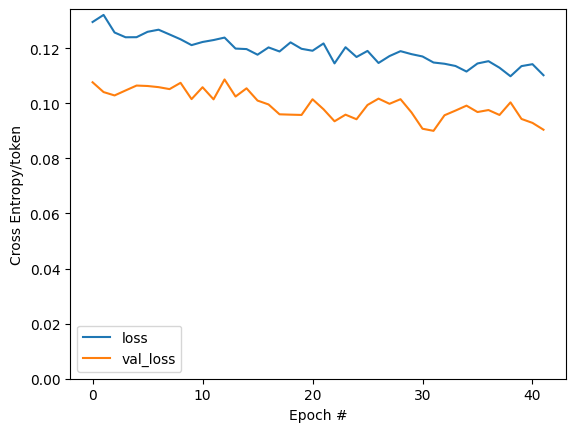

In [157]:
trainer.train(resume_training=True, weights='./weights/lstm-emb128-2rnn128-1dense256-v2.weights.h5')

In [158]:
trainer.save()

Model saved at ./weights/lstm-emb128-2rnn128-1dense256-v3.weights.h5


In [159]:
trainer.save_servant()

INFO:tensorflow:Assets written to: ./servants/lstm-emb128-2rnn128-1dense256-v3\assets


INFO:tensorflow:Assets written to: ./servants/lstm-emb128-2rnn128-1dense256-v3\assets


Saved artifact at './servants/lstm-emb128-2rnn128-1dense256-v3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, None, 18), dtype=tf.float32, name=None)
Captures:
  2504773468624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2504636988304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2504773469968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2504773470160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2504773471696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2504636989072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2504773469200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2504773471120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2504773472848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2504773469008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2504773473040: Te

In [46]:
trainer.model.evaluate(ca_test.take(100))

100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 253ms/step - loss: 0.1226


0.12473190575838089

In [5]:
diacritizer = Diacritizer("servants\lstm-emb128-2rnn128-1dense256", letters_tok, diac_tok)

<>:1: SyntaxWarning: invalid escape sequence '\l'
<>:1: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PrinceEGY\AppData\Local\Temp\ipykernel_40952\3704592007.py:1: SyntaxWarning: invalid escape sequence '\l'
  diacritizer = Diacritizer("servants\lstm-emb128-2rnn128-1dense256", letters_tok, diac_tok)


In [6]:
diacritizer2 = Diacritizer("servants\gru-emb128-2rnn128-1dense256", letters_tok, diac_tok)

<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:1: SyntaxWarning: invalid escape sequence '\g'
C:\Users\PrinceEGY\AppData\Local\Temp\ipykernel_40952\1843825569.py:1: SyntaxWarning: invalid escape sequence '\g'
  diacritizer2 = Diacritizer("servants\gru-emb128-2rnn128-1dense256", letters_tok, diac_tok)


In [7]:
diacritizer3 = Diacritizer("servants\lstm-emb128-2rnn128-1dense256-v2", letters_tok, diac_tok)

<>:1: SyntaxWarning: invalid escape sequence '\l'
<>:1: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PrinceEGY\AppData\Local\Temp\ipykernel_40952\1635509826.py:1: SyntaxWarning: invalid escape sequence '\l'
  diacritizer3 = Diacritizer("servants\lstm-emb128-2rnn128-1dense256-v2", letters_tok, diac_tok)


In [8]:
diacritizer4 = Diacritizer("servants\lstm-emb128-2rnn128-1dense256-v3", letters_tok, diac_tok)

<>:1: SyntaxWarning: invalid escape sequence '\l'
<>:1: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PrinceEGY\AppData\Local\Temp\ipykernel_40952\338063468.py:1: SyntaxWarning: invalid escape sequence '\l'
  diacritizer4 = Diacritizer("servants\lstm-emb128-2rnn128-1dense256-v3", letters_tok, diac_tok)


In [25]:
tx = "هذا النص هو مثال لنص يمكن أن يستبدل في نفس المساحة، لقد تم توليد هذا النص من مولد النص العربى، حيث يمكنك أن تولد مثل هذا النص أو العديد من النصوص الأخرى إضافة إلى زيادة عدد الحروف التى يولدها التطبيق."

In [26]:
diacritizer.diacritize(tx)

'هَذَا النَّصُّ هُوَ مِثَالٌ لِنَصٍّ يُمْكِنُ أَنْ يَسْتَبْدِلَ فِي نَفْسِ الْمِسَاحَةِ، لَقَدْ تَمَّ تَوْلِيدَ هَذَا النَّصِّ مِنْ مَوَلِدِ النَّصِّ الْعُرْبِىِّ، حَيْثُ يُمْكِنُكَ أَنْ تَوَلِّدَ مِثْلَ هَذَا النَّصِّ أَوْ الْعَدِيدِ مِنْ النُّصُوصِ الْأُخْرَى إضَافَةٌ إلَى زِيَادَةِ عَدَدِ الْحُرُوفِ الَّتَّى يُولِّدُهَا التَّطْبِيقُ.'

In [27]:
diacritizer2.diacritize(tx)

'هَذَا النِّصٌّ هُوَ مِثَالٌ لِنَصُّ يُمْكِنُ أَنْ يَسْتَبْدِلَ فِي نَفْسِ الْمُسَاحَةِ، لَقَدْ تَمِّ تَوْلِيدُ هَذَا النِّصٌّ مِنْ مَوْلِدِ النِّصُّ الْعُرْبِىٌّ، حَيْثُ يُمْكَنِكُ أَنْ تَوَلِّدَ مِثْلُ هَذَا النِّصُّ أَوْ الْعَدِيدِ مِنْ النٌّصُوصِ الْأُخْرَى إضَافَةٌ إلَى زِيَادَةِ عَدْدِ الْحُرُوفِ الِّتِى يُولُّدُهَا التِّطْبِيقُ.'

In [28]:
diacritizer3.diacritize(tx)

'هَذَا النَّصُّ هُوَ مِثَالٌ لِنَصٍّ يُمْكِنُ أَنْ يَسْتَبْدِلَ فِي نَفْسِ الْمَسَاحَةِ، لَقَدْ تَمَّ تَوْلِيدُ هَذَا النَّصِّ مِنْ مَوَلَّدِ النَّصِّ الْعُرَبَىُّ، حَيْثُ يُمْكِنُكَ أَنْ تُوَلَدَ مِثْلُ هَذَا النَّصِّ أَوْ الْعَدِيدِ مِنْ النُّصُوصِ الْأُخْرَى إضَافَةٌ إلَى زِيَادَةِ عَدَدِ الْحُرُوفِ الَّتِى يُوَلِّدُهَا التَّطْبِيقُ.'

In [29]:
diacritizer4.diacritize(tx)

'هَذَا النَّصُّ هُوَ مِثَالٌ لِنَصٍّ يُمْكِنُ أَنْ يَسْتَبْدِلَ فِي نَفْسِ الْمَسَاحَّةِ، لَقَدْ تَمَّ تَوْلِيدُ هَذَا النَّصِّ مِنْ مُوَلَّدِ النَّصِّ الْعَرَبِىِّ، حَيْثُ يُمْكِنُكَ أَنْ تُوَلَّدَ مِثْلُ هَذَا النَّصِّ أَوْ الْعَدِيدِ مِنْ النُّصُوصِ الْأُخْرَى إضَافَةٌ إلَى زِيَادَةِ عَدَدِ الْحُرُوفِ الَّتِى يُوَلِّدُهَا التَّطْبِيقُ.'